In [1]:
import cv2
#%pip install moviepy
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib.patches as patches
from src.parser import *
from src.metrics import *
import copy

# Task 2.1: Adaptative modeling

In [2]:
colorspaces = {'grayscale', 'rgb', 'lab', 'hsv'}

## Read video

In [3]:
def read_video(colorspace='grayscale', end_plot=np.Inf):
    file_path = "../datasets/AICity_data/train/S03/c010/vdo.avi"

    cap = cv2.VideoCapture(file_path)

    video_frames = []
    index = 0

    while True:
        ret, frame = cap.read()

        if not ret:
            break
        
        if index < end_plot:
            if colorspace == 'lab':
                video_frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2LAB))
            elif colorspace == 'grayscale':
                video_frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY))
            elif colorspace == 'rgb':
                video_frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            elif colorspace == 'hsv':
                video_frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2HSV))
        else:
            break

        index += 1

    cap.release()
    
    video_frames = np.array(video_frames)
    
    if colorspace == 'lab':
        video_frames = video_frames[:,:,:,1:] # select AB channels
    elif colorspace == 'hsv':
        video_frames = video_frames[:,:,:,:2] # select HS channels
        
    return video_frames

## Model the background with the first 25% of the sequence
First 25 % frames for training

In [4]:
def plot_model_background(video_frames, p1):
    num_channels = video_frames.shape[-1] if video_frames.ndim == 4 else 1

    for num_channel in range(num_channels):
        if num_channels != 1:
            video_frame_channel = video_frames[0:p1,:,:,num_channel]
        else:
            video_frame_channel = video_frames[0:p1,:,:]
        
        fig, ax = plt.subplots(1, 2, figsize=(10,8), dpi=150)
        mean = np.mean(video_frame_channel, axis=0)
        std = np.std(video_frame_channel, axis=0)
        ax[0].imshow(mean)
        ax[0].set_title("Mean channel %d" %num_channel)
        std_img = ax[1].imshow(std, cmap='Reds')
        fig.colorbar(std_img, shrink=0.5)
        ax[1].set_title("Standard deviation channel %d"%num_channel)
        fig.show()

## Segment the foreground and background of the remaining 75% of the sequence

# Adaptative modeling of color

In [5]:
import io

def fig2img(fig):
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    return img

In [46]:
def plot_bboxes_iou(video_frames_arr, bboxes_gt, bboxes_pred, alpha, rho, p1, start_plot, end_plot, gif_filename = "boxplot.gif"):
    boxplot = []
    video_iou = []
    # end_lim = min(end_plot, len(video_frames_arr))
    end_lim = end_plot
    
    for frame_id, frame in enumerate(video_frames_arr[p1:]):
        if end_plot<frame_id:
            break
        fig, ax = plt.subplots(2, 1, figsize=(10,8), dpi=100)

        ax[0].imshow(frame, cmap='gray')
        ax[0].set_title("Alpha=" + str(alpha) + ", Rho=" + str(rho))
        
        ax[0].set_xticks([], [])
        ax[0].set_yticks([], [])
        
        for bboxpred in bboxes_gt[frame_id + p1]:
            ax[0].add_patch(patches.Rectangle((bboxpred['xtl'], bboxpred['ytl']), bboxpred['xbr'] - bboxpred['xtl'], bboxpred['ybr'] - bboxpred['ytl'],
                                                linewidth=2, edgecolor='g', facecolor='none'))
                
        if len(bboxes_pred[frame_id + p1]) == 0:
            mIoU = 0
        else:
            bboxes_curr_iter = bboxes_gt[frame_id + p1].copy()
            
            
            
            for bboxpred in bboxes_pred[frame_id + p1]:
                bboxes_curr_iter.append(bboxpred)
                ax[0].add_patch(patches.Rectangle((bboxpred['xtl'], bboxpred['ytl']), bboxpred['xbr'] - bboxpred['xtl'], bboxpred['ybr'] - bboxpred['ytl'],
                                                  linewidth=2, edgecolor='b', facecolor='none'))
    
            ######### DEBUG

            # print("PRED ",bboxes_pred[frame_id + p1])
            # print("CONCAT" ,bboxes_curr_iter)

            for bbox in bboxes_curr_iter:
                # print("BBOX ", bbox)
                pass
                        
                if bbox['predicted']:
                    pass   
                    # print("OK")
            #######
            mIoU,_,_ = calculate_mean_iou(bboxes_curr_iter)
        
        video_iou.append(mIoU)
        
        plt.plot(list(range(0, frame_id)), video_iou[0:frame_id])
        ax[1].set_title("mean IoU over time")
        
        plt.xlabel('Frame number')
        plt.ylabel('Mean IoU')
        plt.ylim(0,1)
        
        plt.xlim(start_plot, end_lim)
        # print("MEAN IOU ",mIoU)
        
        fig = plt.gcf()
        img = fig2img(fig)
        plt.close()
        boxplot.append(img)
        
    boxplot[0].save(gif_filename, save_all=True, append_images=boxplot, duration=30, loop=0)

In [47]:
def adaptative_modelling(video_frames, alpha=5, rho=0.3, p1=0, bboxes_gt=None, use_morphology=True, compare_with_groundtruth=True):
    num_channels = video_frames.shape[-1] if video_frames.ndim == 4 else 1
    channels = np.arange(0, num_channels, 1)
    
    S = []
    means = []
    stds = []
    
    #initialise with 25%
    for channel in channels:
        if num_channels != 1:
            video_frame_channel = video_frames[0:p1,:,:,channel]
        else:
            video_frame_channel = video_frames[0:p1,:,:]
            
        means.append(np.mean(video_frame_channel, axis=0))
        stds.append(np.std(video_frame_channel, axis=0))
        

    video_frames_out = []
    
    index = 0
    bboxes_pred = {}
    
    for frame_id, frame in enumerate(video_frames[p1:]):        
        S = []
        for channel in channels: 
            if num_channels != 1:
                video_frame_channel = frame[:,:,channel]    
            else:
                video_frame_channel = frame
            
            s_chan = np.where(np.abs(video_frame_channel - means[channel]) >= alpha * (stds[channel] + 2), 255, 0).astype("uint8")
            S.append(s_chan)
            #update mean and std
            means[channel] = np.where(s_chan==255, means[channel], rho*video_frame_channel + (1-rho)*means[channel])
            stds[channel] = np.where(s_chan==255, stds[channel], np.sqrt(rho*(video_frame_channel-means[channel])**2 + (1-rho)*(stds[channel])**2))
        
        s = 1
        for i in range(num_channels):
            s *= (S[i]/255)
        s *= 255    
        
        s = s.astype('uint8')
        
        if use_morphology:
            s = cv2.dilate(s, np.ones((11,11)))
            s = cv2.erode(s, np.ones((11,11)))
            
        if compare_with_groundtruth:
            num_labels, labels_im = cv2.connectedComponents(s)
            # Remove very small objects
            values, counts = np.unique(labels_im, return_counts=True)
            values_small = np.unique(np.where(counts < np.sum(counts)*0.01, values, 0))
            mask = np.isin(labels_im, values_small)
            labels_im[mask] = 0
            im_objects = np.unique(labels_im)
            labels_im_2 = labels_im
            
            bboxes_pred[frame_id + p1] = []
            for im_object_id in im_objects:
                if im_object_id == 0:
                    continue # skip background

                object_im = np.where(labels_im_2==im_object_id, 1, 0)

                object_region = np.where(object_im != 0)    

                bboxes_pred[frame_id + p1].append({'xtl': np.min(object_region[1]),
                                        'ytl': np.min(object_region[0]),
                                        'xbr': np.max(object_region[1]),
                                        'ybr': np.max(object_region[0]),
                                        'outside': None,
                                        'occluded': None,
                                        'keyframe': None,
                                        'parked': None,
                                        'predicted': True,
                                        'detected': False,
                                        'confidence': 1.0})  

        video_frames_out.append(Image.fromarray(s))
        
        if index % 200 == 0:
            print(index)
            
        if index > np.Inf:
            break
        
        index+=1
    
    if compare_with_groundtruth: 
        rec, prec, mAP = voc_eval(bboxes_gt, bboxes_pred)
        print('mAP:', round(mAP, 4), '\n-----------------')
        return s, bboxes_pred, rec, prec, mAP
        
    video_frames_out[0].save("Task2.1_color_lab.gif", save_all=True, append_images=video_frames_out[1:250], duration=30, loop=0)
    return s, bboxes_pred


In [48]:
def release_list(a):
   del a[:]
   del a

In [71]:
def compute_colorspace(colorspace):
    start_plot=0
    end_plot = 250
    # end_plot = 100
    # end_plot = 300
    video_frames = read_video(colorspace=colorspace, end_plot=end_plot)
    
    p1 = int(0.25*len(video_frames)) 
    # plot_model_background(video_frames, p1)
    
    bboxes_gt = parse_xml_not_parked('../datasets/ai_challenge_s03_c010-full_annotation.xml')
    bboxes_gt = {k: v for k, v in bboxes_gt.items() if k >= p1}
    
    alpha = 4
    rho = 0.05
    s, bboxes_pred, rec, prec, mAP  = adaptative_modelling(video_frames, alpha, rho, p1, bboxes_gt, use_morphology=False, compare_with_groundtruth=True)
    
    plt.imshow(s)
    plt.show()
    return
    
    
    plot_bboxes_iou(video_frames_arr=read_video(colorspace='rgb', end_plot=end_plot) , bboxes_gt=bboxes_gt, alpha=alpha, rho=rho, p1=p1,
                    start_plot=start_plot, bboxes_pred=bboxes_pred, end_plot=end_plot, gif_filename = "boxplot.gif")

0
mAP: 0.0909 
-----------------


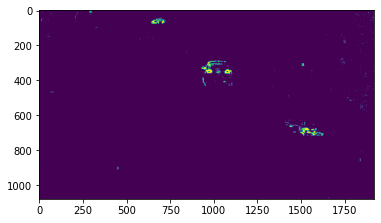

0
mAP: 0.0 
-----------------


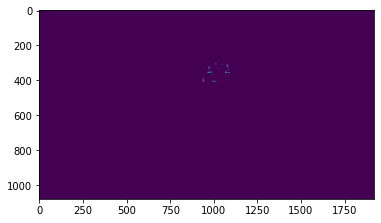

0
mAP: 0.0909 
-----------------


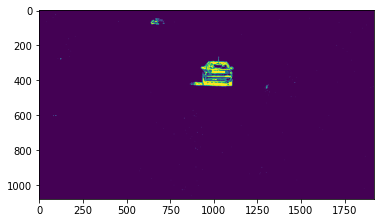

In [72]:
compute_colorspace('hsv')
compute_colorspace('lab')
compute_colorspace('rgb')

0
200
400
600
800
1000
1200
1400
1600
mAP: 0.1792 
-----------------


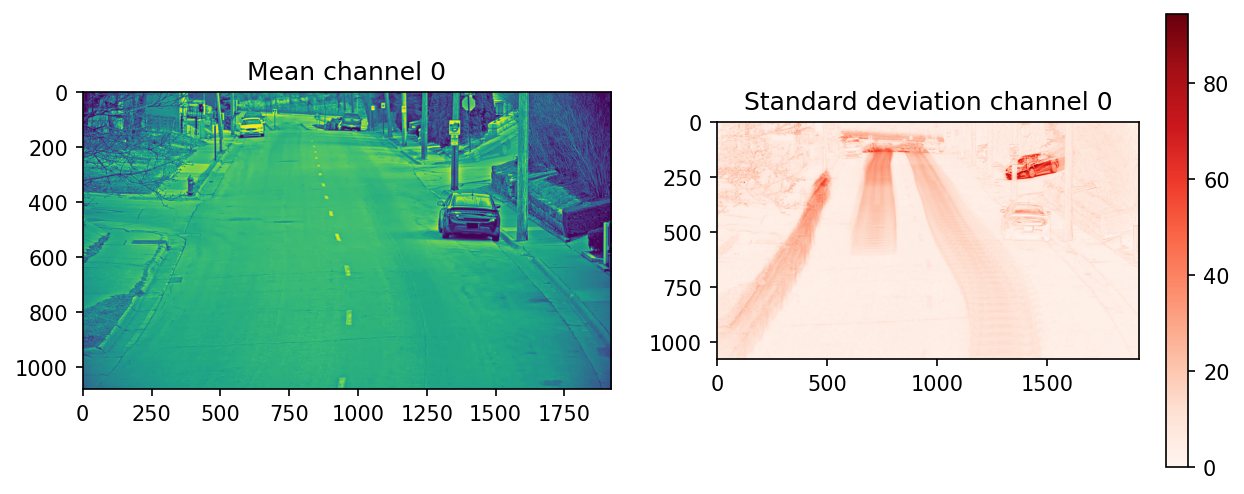

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

In [75]:
compute_colorspace('grayscale')

0
200
mAP: 0.0 
-----------------


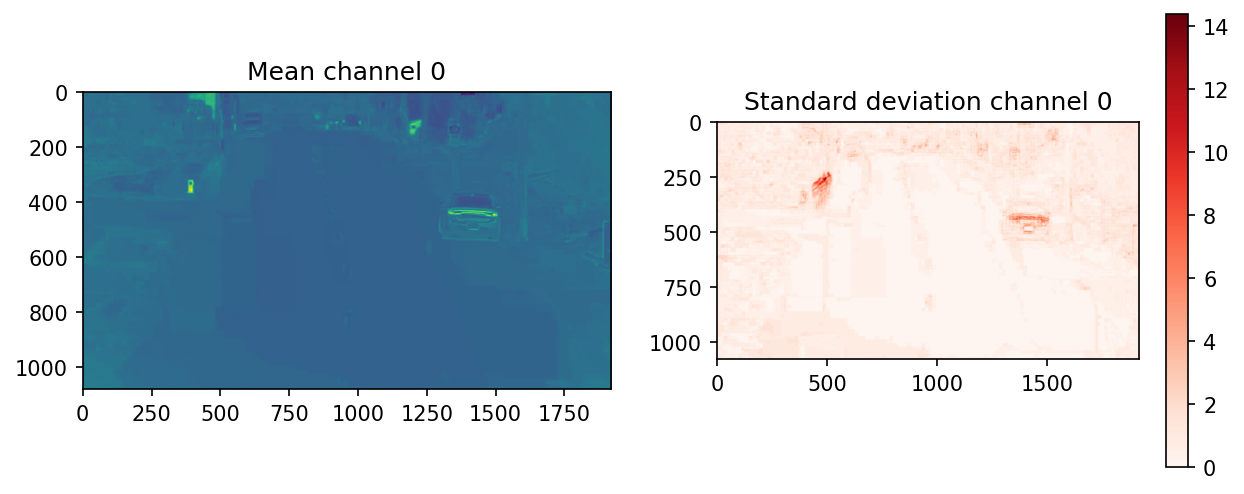

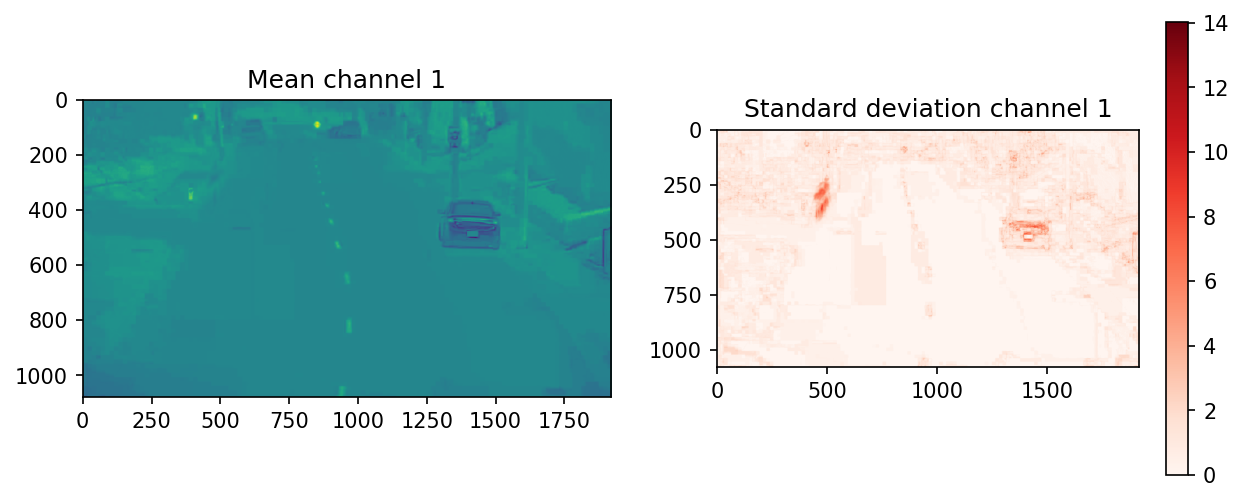

In [60]:
compute_colorspace('lab')

0
200
mAP: 0.0909 
-----------------


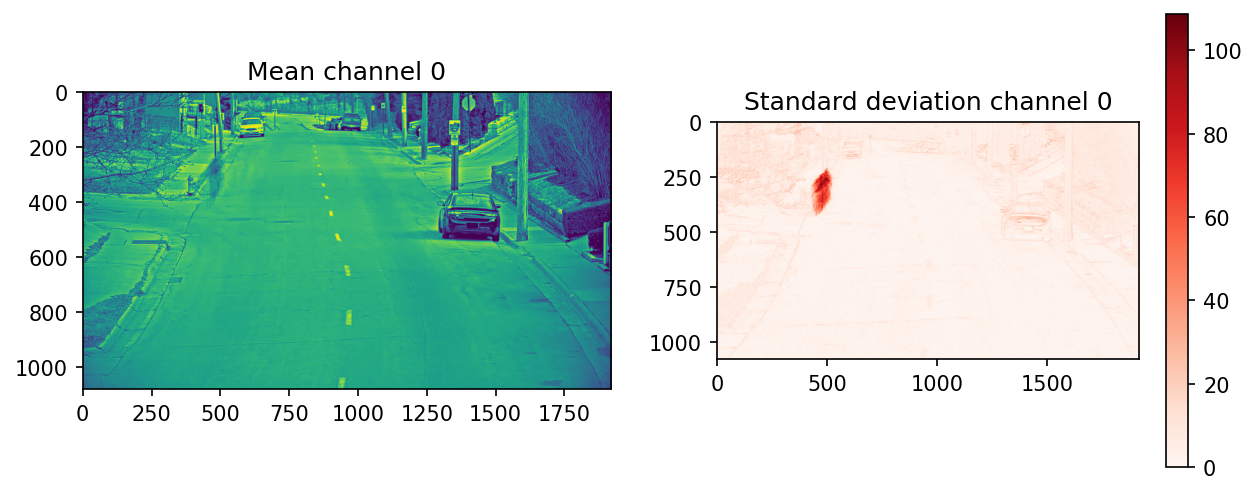

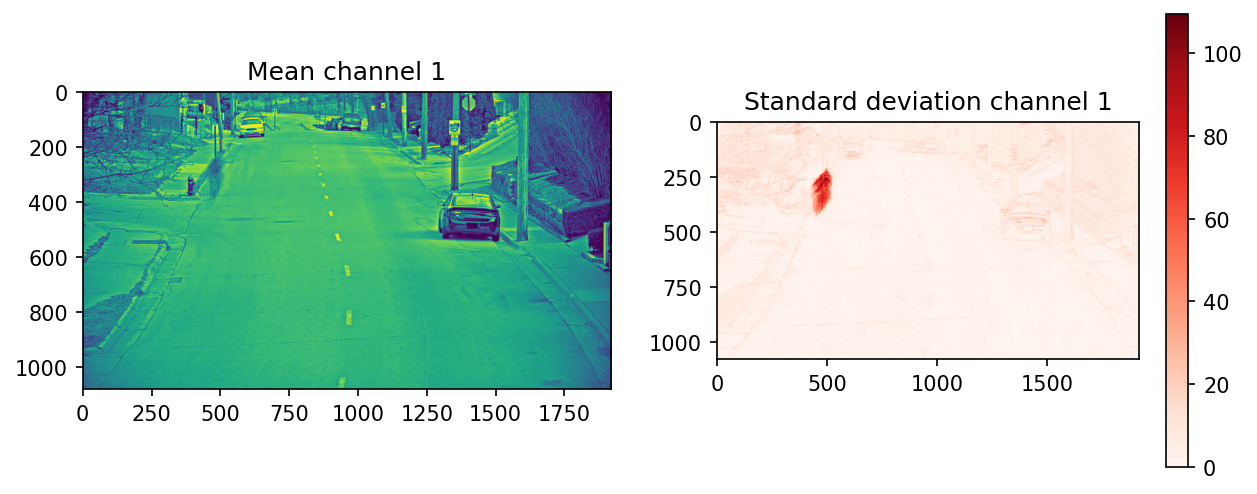

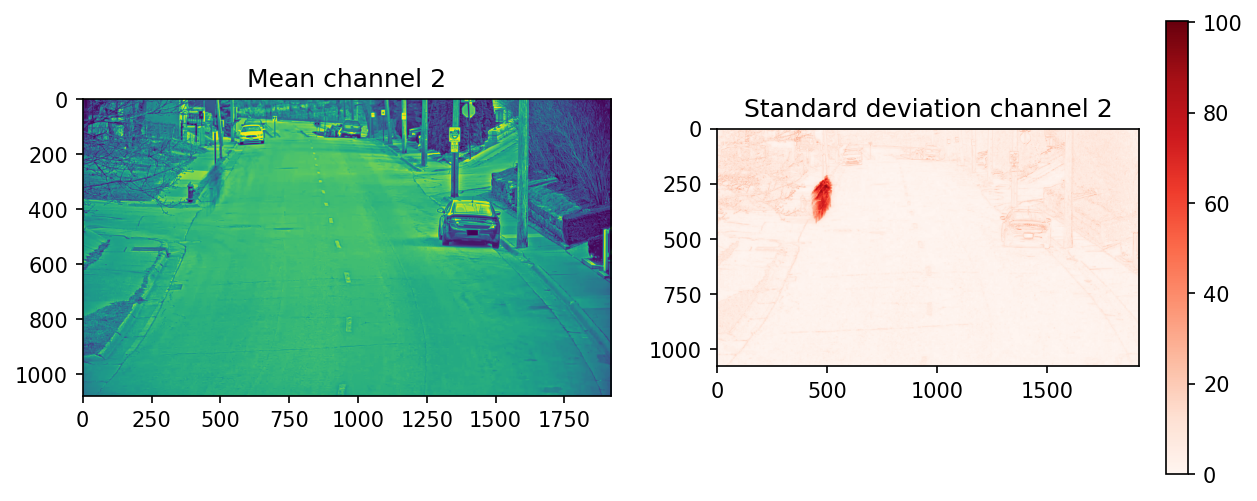

In [61]:
compute_colorspace('rgb')